In [1]:
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA as ICA
from sklearn.random_projection import GaussianRandomProjection as RP
from sklearn.decomposition import PCA,FastICA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as EM

from sklearn import metrics

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import itertools

import time
import timeit
import warnings
warnings.simplefilter('ignore')

In [2]:
def import_data():
    df_ds1 = pd.read_csv("winequality-white.csv", sep=";").append(pd.read_csv("winequality-red.csv", sep=";"), ignore_index=True)
    missing_values = ['?']
    df_ds2 = pd.read_csv("breast-cancer-wisconsin.csv", sep=",",na_values = missing_values)
    df_ds2.fillna(method='ffill',inplace=True)
    X_ds1 = np.array(df_ds1.values[:,1:-1])
    y_ds1 = np.array(df_ds1.values[:,-1])
    y_ds1 = (y_ds1<6).astype(int)
    X_ds2 = np.array(df_ds2.values[:,1:-1])
    y_ds2 = np.array(df_ds2.values[:,-1])
    y_ds2 = (y_ds2<3).astype(int)
#     np.where(y_ds2==2,0,y_ds2)
#     np.where(y_ds2==4,1,y_ds2)
    return df_ds1, df_ds2, X_ds1, y_ds1, X_ds2, y_ds2

In [3]:
def process_data():
    df_Wine, df_BC, X_Wine, Y_Wine, X_BC, Y_BC = import_data()
#     print(Y_Wine, Y_BC)
    X_Wine = df_Wine.drop('quality', axis=1)
    Y_Wine = df_Wine.quality
    Y_Wine.replace([0,1,2,3,4,5],0,inplace=True)
    Y_Wine.replace([6,7,8,9,10],1,inplace=True)
#     print(df_BC.head(5))
    X_BC = df_BC.drop('Class', axis=1)
    Y_BC = df_BC.Class
    Y_BC.replace(2,0,inplace=True)
    Y_BC.replace(4,1,inplace=True)
    sc = StandardScaler()
    X_Wine = sc.fit_transform(X_Wine)
#     print(type(X_Wine))
    X_BC = sc.fit_transform(X_BC)
    return df_Wine, df_BC, X_Wine, Y_Wine, X_BC, Y_BC
    

In [4]:
def train_test(X, y):
    X_train, X_test, y_train, y_test = train_test_split(np.array(X),np.array(y), test_size=0.20)
    sc = preprocessing.StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    return X_train, X_test, y_train, y_test

## Neural Network Functions

In [5]:
def plot_learning_curve_nn(train_sizes, train_mean, train_std, cv_mean, cv_std, title):
    plt.figure()
    plt.plot(train_sizes, train_mean, '', color="b", label="Training Score")
    plt.plot(train_sizes, cv_mean, '', color="r", label="Cross-Validation Score")
    plt.title("Learning Curve For Nueral Network: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("F1 Score")
    plt.legend(loc="best")
    plt.show()

In [6]:
def plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title):
    plt.figure()
    plt.plot(train_sizes, fit_mean, '', color="b", label="Training Time (s)")
    plt.plot(train_sizes, pred_std, '', color="r", label="Prediction Time (s)")
    plt.title("Neural Network model time: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Training Time")
    plt.legend(loc="best")
    plt.show()

In [7]:
def plot_fit_time(n,full_fit,pca_fit,ica_fit,RP_fit,rfc_fit,title):
    plt.figure()
    plt.plot(n, full_fit, '-', color="k", label="Full Dataset")
    plt.plot(n, pca_fit, '-', color="b", label="PCA")
    plt.plot(n, ica_fit, '-', color="r", label="ICA")
    plt.plot(n, RP_fit, '-', color="g", label="RP")
    plt.plot(n, rfc_fit, '-', color="m", label="RFC")
    plt.title("Neural Network: training time: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Training Time")
    plt.legend(loc="best")
    plt.show()

In [8]:
def plot_pred_time(n,full_pred, pca_pred, ica_pred, RP_pred, rfc_pred, title):
    plt.figure()
    plt.plot(n, full_pred, '-', color="k", label="Full Dataset")
    plt.plot(n, pca_pred, '-', color="b", label="PCA")
    plt.plot(n, ica_pred, '-', color="r", label="ICA")
    plt.plot(n, RP_pred, '-', color="g", label="RP")
    plt.plot(n, rfc_pred, '-', color="m", label="RFC")
    plt.title("Neural Network: prediction times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Prediction Time")
    plt.legend(loc="best")
    plt.show()

In [9]:
def plot_learn_time(n,full_learn, pca_learn, ica_learn, RP_learn, rfc_learn, title):
    
    plt.figure()
    plt.plot(n, full_learn, '-', color="k", label="Full Dataset")
    plt.plot(n, pca_learn, '-', color="b", label="PCA")
    plt.plot(n, ica_learn, '-', color="r", label="ICA")
    plt.plot(n, RP_learn, '-', color="g", label="RP")
    plt.plot(n, rfc_learn, '-', color="m", label="RFC")
    plt.title("Neural Network: learning rate: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("F1 Score")
    plt.legend(loc="best")
    plt.show()

In [10]:
def plot_cv_time(n,full_cv, pca_cv, ica_cv, RP_cv, rfc_cv, title):
    
    plt.figure()
    plt.plot(n, full_cv, '-', color="k", label="Full Dataset")
    plt.plot(n, pca_cv, '-', color="b", label="PCA")
    plt.plot(n, ica_cv, '-', color="r", label="ICA")
    plt.plot(n, RP_cv, '-', color="g", label="RP")
    plt.plot(n, rfc_cv, '-', color="m", label="RFC")
    plt.title("Neural Network: cross validation rate: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("F1 Score")
    plt.legend(loc="best")
    plt.show()

In [11]:
def plot_confusion_matrix_nn(clf_dt_best_params_,X_test, y_test):
    titles_options = [("Confusion Matrix", None),
                  ("Confusion Matrix - Sensitivity and Specificity", 'true')]
    
    for title, normalize in titles_options:
        disp = metrics.plot_confusion_matrix(clf_dt_best_params_, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
        
        disp.ax_.set_title(title)
        
    plt.show()

In [12]:
def plot_nn_components(n_components, cv_score, cv_score_em, cv_score_km, xlabel, ylabel, title):
    fig1, ax1 = plt.subplots()
    plt.plot(n_components, cv_score, 'o-',label='without label')
    plt.plot(n_components, cv_score_em,'o-', label='with EM label')
    plt.plot(n_components, cv_score_km,'o-', label='with KMeans label')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc="best")
    plt.show()


In [13]:
def classification_report(clf,X_train, X_test, y_train, y_test):
    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()    
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    auc = metrics.roc_auc_score(y_test, y_pred)

    f1 = metrics.f1_score(y_test,y_pred)
    accuracy = metrics.accuracy_score(y_test,y_pred)
    precision = metrics.precision_score(y_test,y_pred)
    recall = metrics.recall_score(y_test,y_pred)
    cm = metrics.confusion_matrix(y_test,y_pred)

    print("Classification Report")
    print("*****************************************************")
    print("Training Time:   "+"{:.5f}".format(training_time))
    print("Prediction Time: "+"{:.5f}\n".format(pred_time))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    print(metrics.classification_report(y_test, y_pred))
    print("*****************************************************")
    plot_confusion_matrix_nn(clf, X_test, y_test)

In [14]:
def evaluate_nn(clf, X, y, title="Insert Title"):
    train_mean = []
    train_std = [] 
    cv_mean = []
    cv_std = [] 
    fit_mean = []
    fit_std = [] 
    pred_mean = []
    pred_std = []
    train_sizes=(np.linspace(.05, 1.0, 50)* len(y) ).astype('int')  
    
    for i in train_sizes:
        idx = np.random.randint(X.shape[0], size=i)
        X_subset = X[idx,:]
        y_subset = y[idx]
        scores = cross_validate(clf, X_subset, y_subset, cv=10, scoring='f1', n_jobs=-1, return_train_score=True)
       
        train_mean.append(np.mean(scores['train_score']))
        train_std.append(np.std(scores['train_score']))
        cv_mean.append(np.mean(scores['test_score']))
        cv_std.append(np.std(scores['test_score']))
        fit_mean.append(np.mean(scores['fit_time']))
        fit_std.append(np.std(scores['fit_time']))
        pred_mean.append(np.mean(scores['score_time']))
        pred_std.append(np.std(scores['score_time']))
    
    train_mean = np.array(train_mean); train_std = np.array(train_std)
    cv_mean = np.array(cv_mean); cv_std = np.array(cv_std)
    fit_mean = np.array(fit_mean); fit_std = np.array(fit_std)
    pred_mean = np.array(pred_mean); pred_std = np.array(pred_std)
    
    plot_learning_curve_nn(train_sizes, train_mean, train_std, cv_mean, cv_std, title)
    plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title)

    
    return train_sizes, train_mean, fit_mean, pred_mean, cv_mean

In [15]:
def analyze_nn_components(alg,X,Y,components,classes,df=None,column=None,km_val=None):
    n_classes = classes # 2
    time_pca = []
    n_components = components # range(1,8)
    cv_score = []
    cv_score_em = []
    cv_score_km = []
    X_transformed = None
    clust = None
    clust_km = None
    clust_em = None
    if km_val == None:
        km_components = KMeans(n_clusters=n_classes,n_init=10,random_state=100,n_jobs=-1).fit(X)
    else:
        km_components = km_val
    km_labels = km_components.labels_
#     print('km_labels',km_labels)

#     nodes_hidden_layer = int((comp + n_classes)/2)
    nodes_hidden_layer = (10,5,5)
    #neural network learner
#     mlp = MLPClassifier(hidden_layer_sizes=(nodes_hidden_layer,),max_iter=5000,random_state=18)
    mlp = MLPClassifier(hidden_layer_sizes=nodes_hidden_layer,learning_rate_init=0.01,max_iter=5000,random_state=18)

    for comp in n_components:

#     #     nodes_hidden_layer = int((comp + n_classes)/2)
#         nodes_hidden_layer = (10,5,5)
#         #neural network learner
#     #     mlp = MLPClassifier(hidden_layer_sizes=(nodes_hidden_layer,),max_iter=5000,random_state=18)
#         mlp = MLPClassifier(hidden_layer_sizes=nodes_hidden_layer,learning_rate_init=0.01,max_iter=5000,random_state=18)

        if alg == 'PCA':
            X_transformed = pca_cluster(X,comp,18)
        elif alg == 'ICA':
             X_transformed = ica_cluster(X,comp,18)
        elif alg == 'RP':
             X_transformed = RP_cluster(X,comp,18)
        elif alg == 'RFC':
            imp_rf, top_cols_rf = run_RFC(X,Y,df.drop(column, axis=1),500,5,-1)
            X_transformed = rf_cluster(df, column, top_cols_rf)

        
        cv_score.append(np.mean(cross_val_score(mlp, X_transformed, Y, cv = 3)))


        
#         print('km: ', km,'km_labels: ', km_labels)
        em = EM(n_components=comp,covariance_type='full',n_init=1,warm_start=True,random_state=18).fit(X)
        em_labels = em.predict(X)
#         print('em: ', em,'em_labels: ', em_labels)
#         print('km_labels',km_labels)
        clust = get_clusters(X_transformed,km_labels,em_labels)

        clust_km = clust[:,0:1]
        clust_em = clust[:,1:2]

        X_transformed_em = np.concatenate((X_transformed, clust_em), axis=1)


        cv_score_em.append(np.mean(cross_val_score(mlp, X_transformed_em, Y, cv = 10)))
    #     cv_score_em_pca.append(np.mean(cross_val_score(mlp, X_transformed_em_pca, y_ds2)))


        X_transformed_km = np.concatenate((X_transformed, clust_km), axis=1)


        cv_score_km.append(np.mean(cross_val_score(mlp, X_transformed_km, Y, cv = 10)))
    #     cv_score_km_pca.append(np.mean(cross_val_score(mlp, X_transformed_km_pca, y_ds2)))
    return n_components, cv_score, cv_score_em, cv_score_km

In [16]:
def get_clusters(X,km_lables,em_lables):
    __X,__km_labels,__em_lables = X,km_lables,em_lables
#     print('X: ',__X,'km_labels: ', __km_labels,'em_lables: ', __em_lables)
    df = pd.DataFrame(__X)
    df['KM Cluster'] = __km_labels
    df['EM Cluster'] = __em_lables
    col_1hot = ['KM Cluster', 'EM Cluster']
    df_1hot = df[col_1hot]
    df_1hot = pd.get_dummies(df_1hot).astype('category')
    df_others = df.drop(col_1hot,axis=1)
    df = pd.concat([df_others,df_1hot],axis=1)
#     df = pd.concat([df_1hot],axis=1)
    X_cluster = np.array(df.values,dtype='int64')   
    
    return X_cluster

In [17]:
def run_RFC(X,y,df_original,n_estimators,random_state,n_jobs):
    rfc = RFC(n_estimators=n_estimators,min_samples_leaf=round(len(X)*.01),random_state=random_state,n_jobs=n_jobs)
    imp = rfc.fit(X,y).feature_importances_ 
    imp = pd.DataFrame(imp,columns=['Feature Importance'],index=df_original.columns)
    imp.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
    imp['Cum Sum'] = imp['Feature Importance'].cumsum()
    imp = imp[imp['Cum Sum']<=0.87]
    top_cols = imp.index.tolist()
    return imp, top_cols

In [18]:
def pca_cluster(X,n_components,random_state):
    pca_cluster = PCA(n_components=n_components,random_state=random_state).fit_transform(X)
    return pca_cluster

In [19]:
def ica_cluster(X,n_components,random_state):
    ica_cluster = FastICA(n_components = n_components,whiten=True, random_state= random_state).fit_transform(X)
    return ica_cluster

In [20]:
def RP_cluster(X,n_components,random_state):
    RP_cluster = RP(n_components = n_components, random_state= random_state).fit_transform(X)
    return RP_cluster

In [21]:
def rf_cluster(df_ds, column, top_cols):
    rf_cluster =  df_ds.drop(column, axis=1)[top_cols]
    return rf_cluster

# Load Datasets

In [22]:
# df_Wine, df_BC, X_Wine, Y_Wine, X_BC, Y_BC = process_data()

df_BC, df_Wine, X_BC, Y_BC, X_Wine, Y_Wine = process_data()

In [23]:
print(X_BC)

[[-0.16608919 -0.42318303  0.28468605 ... -1.35904886 -0.54617826
  -1.41855821]
 [-0.70607349 -0.24094936  0.14704613 ...  0.50691489 -0.27735097
  -0.83161516]
 [ 0.68245757 -0.36243847  0.55996589 ...  0.25811972 -0.61338508
  -0.32852111]
 ...
 [-0.70607349  1.03468634 -1.29817304 ...  1.25330039  1.47002637
   0.42611996]
 [-1.01463595  1.85473786 -1.366993   ...  2.18628226  1.20119908
  -0.2446721 ]
 [-0.93749534 -0.1802048   1.04170561 ...  1.06670401  0.86516498
   0.42611996]]


In [24]:
print((np.linspace(.05, 1.0, 20)* (len(Y_BC) ) ).astype('int') )

[ 324  649  974 1299 1624 1949 2273 2598 2923 3248 3573 3898 4223 4547
 4872 5197 5522 5847 6172 6497]


# Neural Network - Component Analysis

#### PCA

In [25]:
km_components = KMeans(n_clusters=4,n_init=10,random_state=18,n_jobs=-1).fit(X_BC)
n_components_pca, cv_score_pca, cv_score_em_pca, cv_score_km_pca = analyze_nn_components('PCA',X_BC,Y_BC,range(2,11),4,km_val=km_components)


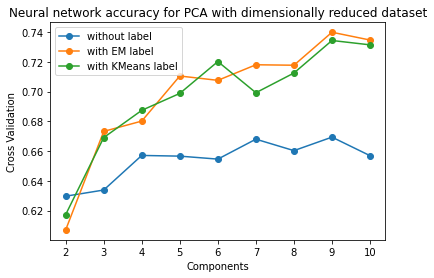

In [26]:
plot_nn_components(n_components_pca, cv_score_pca, cv_score_em_pca, cv_score_km_pca, 'Components', 'Cross Validation', 'Neural network accuracy for PCA with dimensionally reduced dataset')


#### ICA

In [27]:
km_components = KMeans(n_clusters=4,n_init=10,random_state=18,n_jobs=-1).fit(X_BC)
n_components_ica, cv_score_ica, cv_score_em_ica, cv_score_km_ica = analyze_nn_components('ICA',X_BC,Y_BC,range(2,11),4,km_val=km_components)


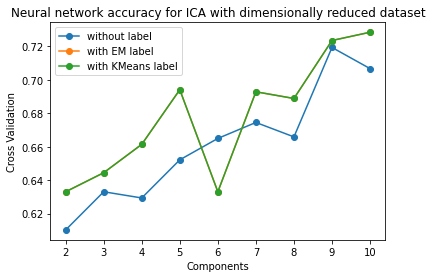

In [28]:
plot_nn_components(n_components_ica, cv_score_ica, cv_score_em_ica, cv_score_km_ica, 'Components', 'Cross Validation', 'Neural network accuracy for ICA with dimensionally reduced dataset')


#### Randomize Projection

In [29]:
km_components = KMeans(n_clusters=4,n_init=10,random_state=100,n_jobs=-1).fit(X_BC)
n_components_RP, cv_score_RP, cv_score_em_RP, cv_score_km_RP = analyze_nn_components('RP',X_BC,Y_BC,range(2,11),4,km_val=km_components)


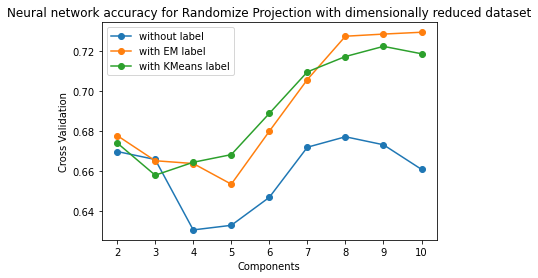

In [30]:
plot_nn_components(n_components_RP, cv_score_RP, cv_score_em_RP, cv_score_km_RP, 'Components', 'Cross Validation', 'Neural network accuracy for Randomize Projection with dimensionally reduced dataset')


#### Random Forest Classifier

In [31]:
km_components = KMeans(n_clusters=4,n_init=10,random_state=100,n_jobs=-1).fit(X_BC)
n_components_rfc, cv_score_rfc, cv_score_em_rfc, cv_score_km_rfc = analyze_nn_components('RFC',X_BC,Y_BC,range(2,11),4,df=df_BC,column='quality',km_val=km_components)


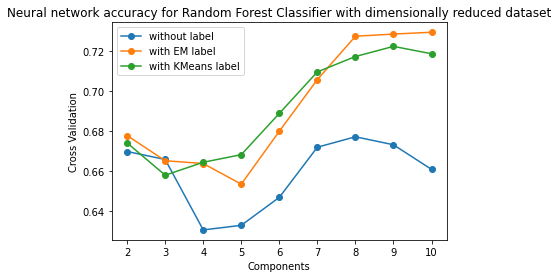

In [32]:
plot_nn_components(n_components_RP, cv_score_RP, cv_score_em_RP, cv_score_km_RP, 'Components', 'Cross Validation', 'Neural network accuracy for Random Forest Classifier with dimensionally reduced dataset')


# Training Neural Network on Projected Data

In [33]:
# imp_rf_BC, top_cols_rf_BC = run_RFC(X_BC,Y_BC,df_BC.drop('Class', axis=1),500,5,-1)
imp_rf_BC, top_cols_rf_BC = run_RFC(X_BC,Y_BC,df_BC.drop('quality', axis=1),500,5,-1)

In [34]:
# X_pca_cluster_BC = pca_cluster(X_BC,6,5)
# X_ica_cluster_BC = ica_cluster(X_BC,12,5)
# X_RP_cluster_BC = RP_cluster(X_BC,8,5)
# # X_rf_cluster_BC = rf_cluster(df_BC, 'Class', top_cols_rf_BC)
# X_rf_cluster_BC = rf_cluster(df_BC, 'quality', top_cols_rf_BC)

In [35]:
X_pca_cluster_BC = pca_cluster(X_BC,4,18)
X_ica_cluster_BC = ica_cluster(X_BC,4,18)
X_RP_cluster_BC = RP_cluster(X_BC,4,18)
# X_rf_cluster_BC = rf_cluster(df_BC, 'Class', top_cols_rf_BC)
X_rf_cluster_BC = rf_cluster(df_BC, 'quality', top_cols_rf_BC)

In [36]:
# X_pca_cluster_BC = pca_cluster(X_BC,8,5)
# X_ica_cluster_BC = ica_cluster(X_BC,5,5)
# X_RP_cluster_BC = RP_cluster(X_BC,5,5)
# # X_rf_cluster_BC = rf_cluster(df_BC, 'Class', top_cols_rf_BC)
# X_rf_cluster_BC = rf_cluster(df_BC, 'quality', top_cols_rf_BC)

#### Full Dataset

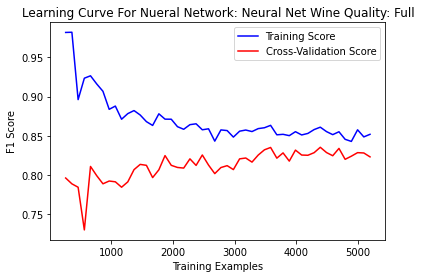

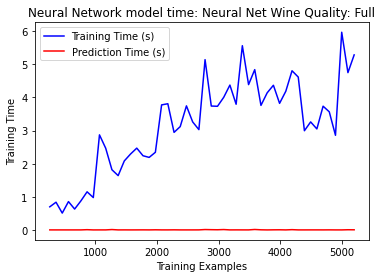

Classification Report
*****************************************************
Training Time:   3.27753
Prediction Time: 0.00087

F1 Score:  0.82
Accuracy:  0.78     AUC:       0.77
Precision: 0.83     Recall:    0.82
*****************************************************
              precision    recall  f1-score   support

           0       0.70      0.72      0.71       490
           1       0.83      0.82      0.82       810

    accuracy                           0.78      1300
   macro avg       0.77      0.77      0.77      1300
weighted avg       0.78      0.78      0.78      1300

*****************************************************


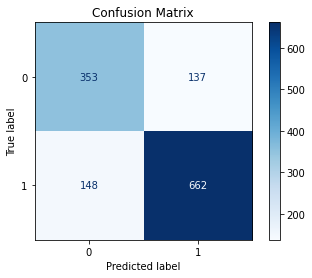

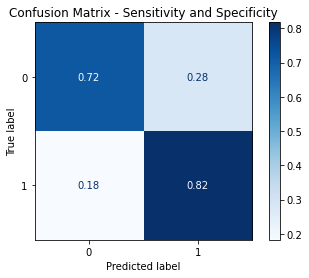

In [37]:
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test(X_BC, Y_BC)
full_est = MLPClassifier(hidden_layer_sizes=(10,5,5), solver='adam', activation='relu', learning_rate_init=0.01, max_iter=10000, random_state=18)
train_samp_full, NN_train_score_full, NN_fit_time_full, NN_pred_time_full, NN_cv_score_full = evaluate_nn(full_est, X_train_nn, y_train_nn,title="Neural Net Wine Quality: Full")
classification_report(full_est, X_train_nn, X_test_nn, y_train_nn, y_test_nn)

#### PCA

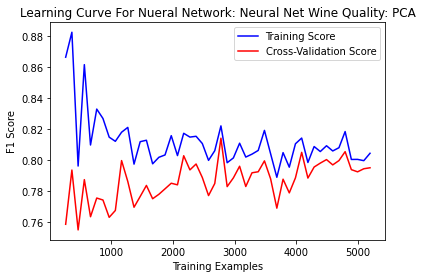

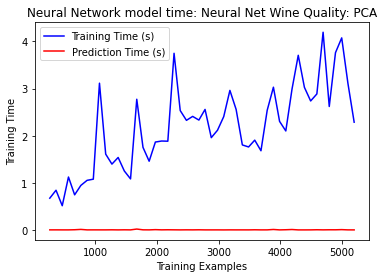

Classification Report
*****************************************************
Training Time:   1.27316
Prediction Time: 0.00241

F1 Score:  0.77
Accuracy:  0.71     AUC:       0.70
Precision: 0.79     Recall:    0.76
*****************************************************
              precision    recall  f1-score   support

           0       0.59      0.64      0.61       459
           1       0.79      0.76      0.77       841

    accuracy                           0.71      1300
   macro avg       0.69      0.70      0.69      1300
weighted avg       0.72      0.71      0.72      1300

*****************************************************


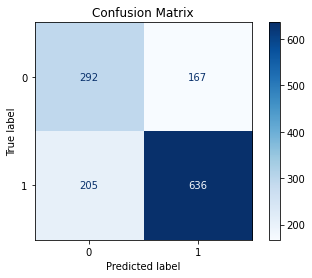

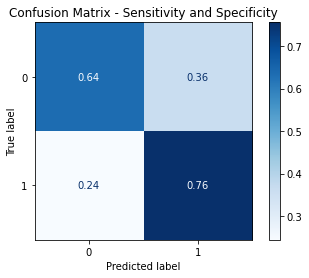

In [38]:
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test(X_pca_cluster_BC, Y_BC)
pca_est = MLPClassifier(hidden_layer_sizes=(10,5,5), solver='adam', activation='relu', learning_rate_init=0.01, max_iter=10000, random_state=18)
train_samp_pca, NN_train_score_pca, NN_fit_time_pca, NN_pred_time_pca, NN_cv_score_pca = evaluate_nn(pca_est, X_train_nn, y_train_nn,title="Neural Net Wine Quality: PCA")
classification_report(pca_est, X_train_nn, X_test_nn, y_train_nn, y_test_nn)

#### ICA

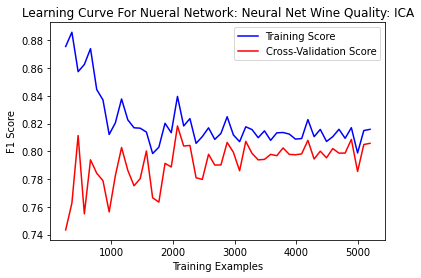

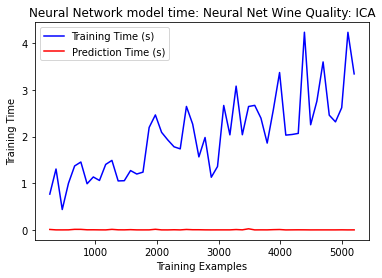

Classification Report
*****************************************************
Training Time:   1.36220
Prediction Time: 0.00084

F1 Score:  0.79
Accuracy:  0.73     AUC:       0.70
Precision: 0.76     Recall:    0.83
*****************************************************
              precision    recall  f1-score   support

           0       0.66      0.57      0.61       490
           1       0.76      0.83      0.79       810

    accuracy                           0.73      1300
   macro avg       0.71      0.70      0.70      1300
weighted avg       0.72      0.73      0.72      1300

*****************************************************


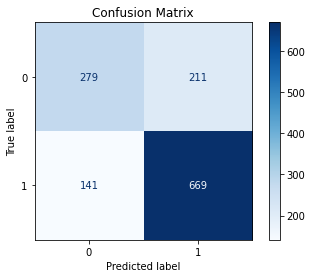

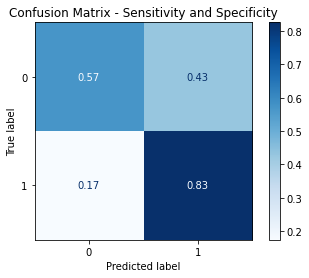

In [39]:
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test(X_ica_cluster_BC, Y_BC)
ica_est = MLPClassifier(hidden_layer_sizes=(10,5,5), solver='adam', activation='relu', learning_rate_init=0.01, max_iter=10000, random_state=18)
train_samp_ica, NN_train_score_ica, NN_fit_time_ica, NN_pred_time_ica, NN_cv_score_ica = evaluate_nn(ica_est, X_train_nn, y_train_nn,title="Neural Net Wine Quality: ICA")
classification_report(ica_est, X_train_nn, X_test_nn, y_train_nn, y_test_nn )

#### Randomize Projection

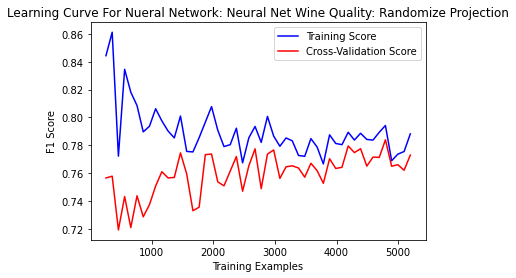

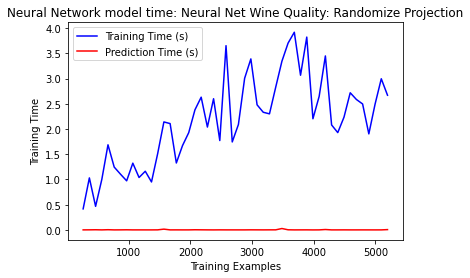

Classification Report
*****************************************************
Training Time:   2.45994
Prediction Time: 0.00095

F1 Score:  0.76
Accuracy:  0.70     AUC:       0.67
Precision: 0.75     Recall:    0.77
*****************************************************
              precision    recall  f1-score   support

           0       0.60      0.58      0.59       487
           1       0.75      0.77      0.76       813

    accuracy                           0.70      1300
   macro avg       0.67      0.67      0.67      1300
weighted avg       0.69      0.70      0.69      1300

*****************************************************


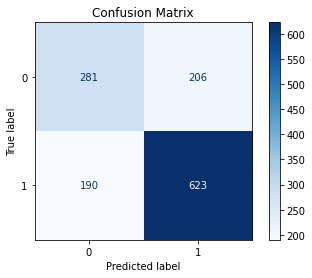

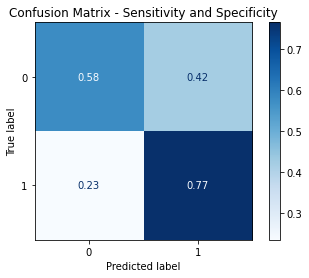

In [40]:
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test(X_RP_cluster_BC, Y_BC)
RP_est = MLPClassifier(hidden_layer_sizes=(10,5,5), solver='adam', activation='relu', learning_rate_init=0.01, max_iter=10000, random_state=18)
train_samp_RP, NN_train_score_RP, NN_fit_time_RP, NN_pred_time_RP, NN_cv_score_RP = evaluate_nn(RP_est, X_train_nn, y_train_nn,title="Neural Net Wine Quality: Randomize Projection")
classification_report(RP_est, X_train_nn, X_test_nn, y_train_nn, y_test_nn )

#### Random Forest Classifier

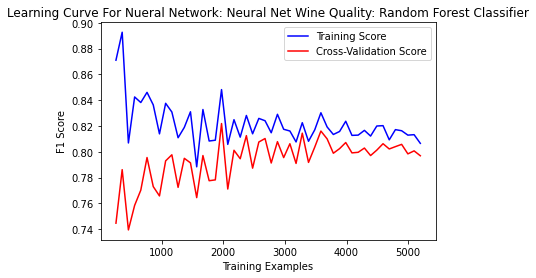

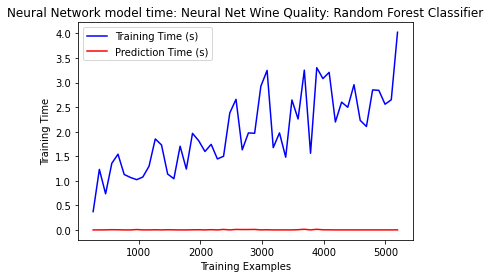

Classification Report
*****************************************************
Training Time:   4.80027
Prediction Time: 0.00150

F1 Score:  0.78
Accuracy:  0.70     AUC:       0.67
Precision: 0.74     Recall:    0.81
*****************************************************
              precision    recall  f1-score   support

           0       0.62      0.52      0.57       482
           1       0.74      0.81      0.78       818

    accuracy                           0.70      1300
   macro avg       0.68      0.67      0.67      1300
weighted avg       0.70      0.70      0.70      1300

*****************************************************


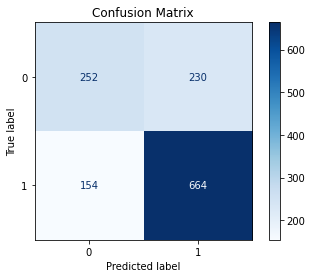

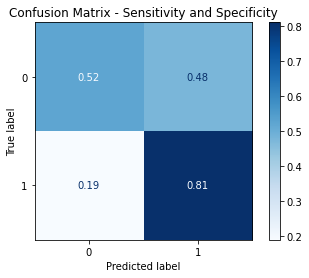

In [41]:
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test(X_ica_cluster_BC, Y_BC)
rfc_est = MLPClassifier(hidden_layer_sizes=(10,5,5), solver='adam', activation='relu', learning_rate_init=0.01, max_iter=10000, random_state=18)
train_samp_rfc, NN_train_score_rfc, NN_fit_time_rfc, NN_pred_time_rfc, NN_cv_score_rfc = evaluate_nn(rfc_est, X_train_nn, y_train_nn,title="Neural Net Wine Quality: Random Forest Classifier")
classification_report(rfc_est, X_train_nn, X_test_nn, y_train_nn, y_test_nn)

#### Comparision plots

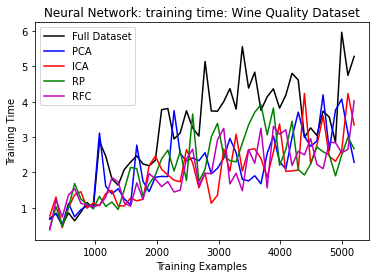

In [42]:
plot_fit_time(train_samp_full, NN_fit_time_full, NN_fit_time_pca, NN_fit_time_ica, NN_fit_time_RP, NN_fit_time_rfc, 'Wine Quality Dataset')       

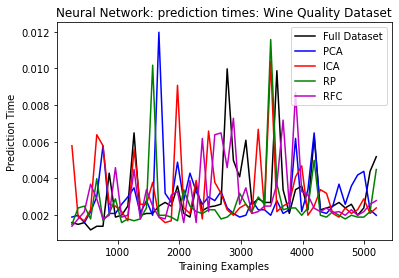

In [43]:
plot_pred_time(train_samp_full, NN_pred_time_full, NN_pred_time_pca, NN_pred_time_ica, NN_pred_time_RP, NN_pred_time_rfc, 'Wine Quality Dataset')   

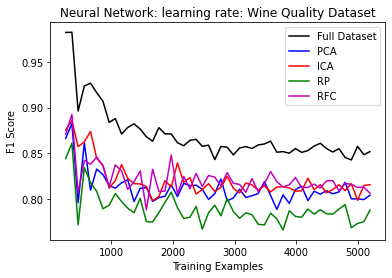

In [44]:
plot_learn_time(train_samp_full, NN_train_score_full, NN_train_score_pca, NN_train_score_ica, NN_train_score_RP, NN_train_score_rfc, 'Wine Quality Dataset')

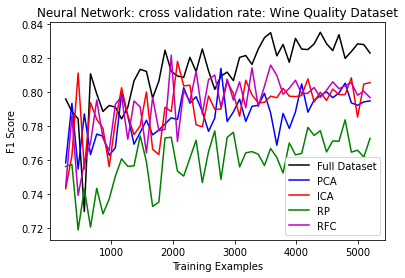

In [45]:
plot_cv_time(train_samp_full,NN_cv_score_full, NN_cv_score_pca, NN_cv_score_ica, NN_cv_score_RP, NN_cv_score_rfc, 'Wine Quality Dataset')

# Training Neural Network on Projected Data with Cluster Labels

In [46]:
# km = KMeans(n_clusters=9,n_init=10,random_state=100,n_jobs=-1).fit(X_BC)
# km_labels = km.labels_
# em = EM(n_components=24,covariance_type='diag',n_init=1,warm_start=True,random_state=100).fit(X_BC)
# em_labels = em.predict(X_BC)

km = KMeans(n_clusters=5,n_init=10,random_state=18,n_jobs=-1).fit(X_BC)
km_labels = km.labels_
em = EM(n_components=7,covariance_type='diag',n_init=1,warm_start=True,random_state=18).fit(X_BC)
em_labels = em.predict(X_BC)

clust_full = get_clusters(X_BC,km_labels,em_labels)
clust_pca = get_clusters(X_pca_cluster_BC,km_labels,em_labels)
clust_ica = get_clusters(X_ica_cluster_BC,km_labels,em_labels)
clust_RP = get_clusters(X_RP_cluster_BC,km_labels,em_labels)
clust_rfc = get_clusters(X_rf_cluster_BC,km_labels,em_labels)

#### Full Cluster

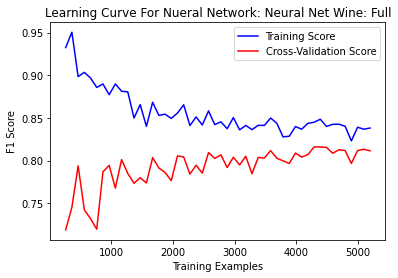

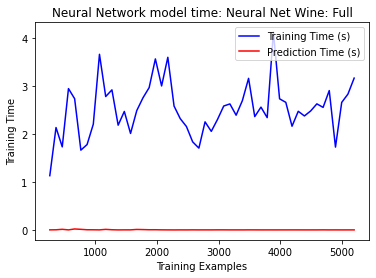

Classification Report
*****************************************************
Training Time:   1.69500
Prediction Time: 0.00116

F1 Score:  0.79
Accuracy:  0.71     AUC:       0.66
Precision: 0.74     Recall:    0.84
*****************************************************
              precision    recall  f1-score   support

           0       0.63      0.49      0.55       470
           1       0.74      0.84      0.79       830

    accuracy                           0.71      1300
   macro avg       0.69      0.66      0.67      1300
weighted avg       0.70      0.71      0.70      1300

*****************************************************


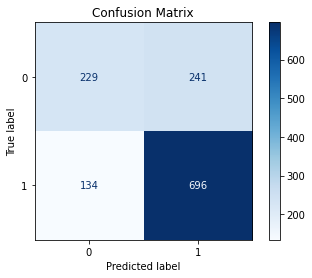

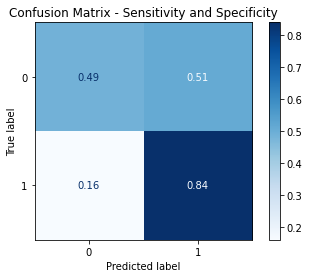

In [47]:
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test(clust_full, Y_BC)
full_est_lbl = MLPClassifier(hidden_layer_sizes=(10,5,5), solver='adam', activation='relu', learning_rate_init=0.01, max_iter=10000, random_state=18)
train_samp_full_lbl, NN_train_score_full_lbl, NN_fit_time_full_lbl, NN_pred_time_full_lbl, NN_cv_score_full_lbl = evaluate_nn(full_est_lbl, X_train_nn, y_train_nn,title="Neural Net Wine: Full")
classification_report(full_est_lbl, X_train_nn, X_test_nn, y_train_nn, y_test_nn)

#### PCA

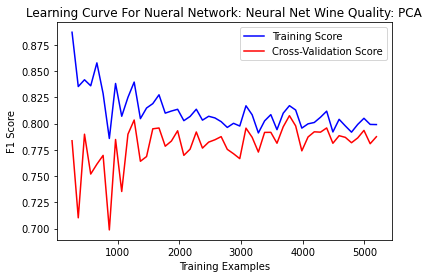

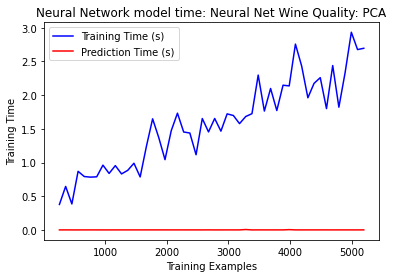

Classification Report
*****************************************************
Training Time:   1.78400
Prediction Time: 0.00078

F1 Score:  0.78
Accuracy:  0.70     AUC:       0.66
Precision: 0.74     Recall:    0.82
*****************************************************
              precision    recall  f1-score   support

           0       0.62      0.51      0.56       480
           1       0.74      0.82      0.78       820

    accuracy                           0.70      1300
   macro avg       0.68      0.66      0.67      1300
weighted avg       0.69      0.70      0.69      1300

*****************************************************


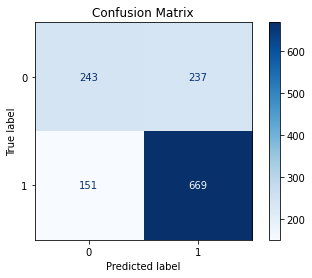

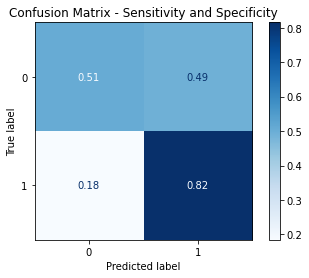

In [48]:
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test(clust_pca, Y_BC)
pca_est_lbl = MLPClassifier(hidden_layer_sizes=(10,5,5), solver='adam', activation='relu', learning_rate_init=0.01, max_iter=10000, random_state=18)
train_samp_pca_lbl, NN_train_score_pca_lbl, NN_fit_time_pca_lbl, NN_pred_time_pca_lbl, NN_cv_score_pca_lbl = evaluate_nn(pca_est_lbl, X_train_nn, y_train_nn,title="Neural Net Wine Quality: PCA")
classification_report(pca_est_lbl, X_train_nn, X_test_nn, y_train_nn, y_test_nn)

#### ICA

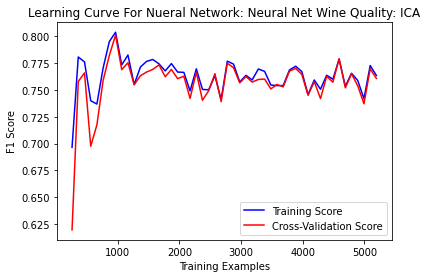

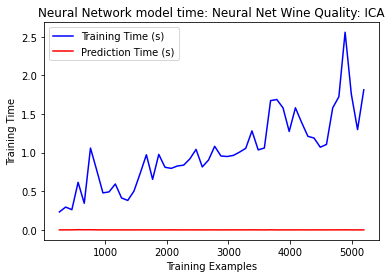

Classification Report
*****************************************************
Training Time:   1.36675
Prediction Time: 0.00084

F1 Score:  0.77
Accuracy:  0.67     AUC:       0.59
Precision: 0.69     Recall:    0.87
*****************************************************
              precision    recall  f1-score   support

           0       0.58      0.32      0.41       470
           1       0.69      0.87      0.77       830

    accuracy                           0.67      1300
   macro avg       0.63      0.59      0.59      1300
weighted avg       0.65      0.67      0.64      1300

*****************************************************


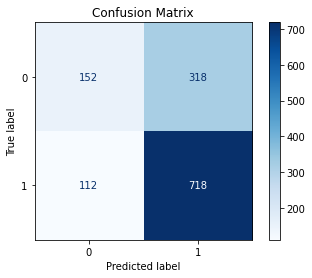

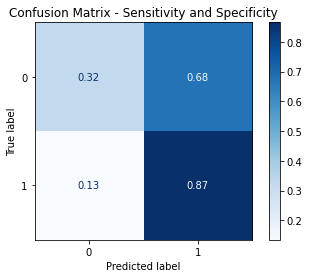

In [49]:
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test(clust_ica, Y_BC)
ica_est_lbl = MLPClassifier(hidden_layer_sizes=(10,5,5), solver='adam', activation='relu', learning_rate_init=0.01, max_iter=10000, random_state=18)
train_samp_ica_lbl, NN_train_score_ica_lbl, NN_fit_time_ica_lbl, NN_pred_time_ica_lbl, NN_cv_score_ica_lbl = evaluate_nn(ica_est_lbl, X_train_nn, y_train_nn,title="Neural Net Wine Quality: ICA")
classification_report(ica_est_lbl, X_train_nn, X_test_nn, y_train_nn, y_test_nn )

#### Randomized Projection

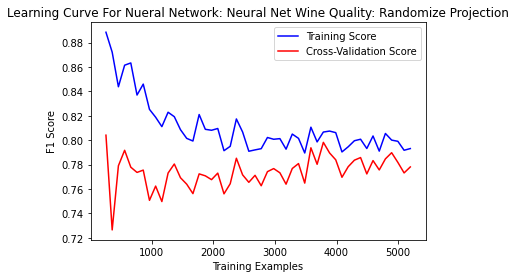

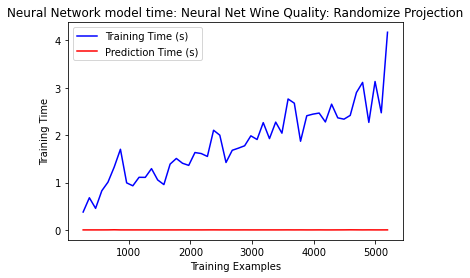

Classification Report
*****************************************************
Training Time:   1.51111
Prediction Time: 0.00079

F1 Score:  0.74
Accuracy:  0.67     AUC:       0.63
Precision: 0.72     Recall:    0.77
*****************************************************
              precision    recall  f1-score   support

           0       0.56      0.50      0.53       483
           1       0.72      0.77      0.74       817

    accuracy                           0.67      1300
   macro avg       0.64      0.63      0.64      1300
weighted avg       0.66      0.67      0.66      1300

*****************************************************


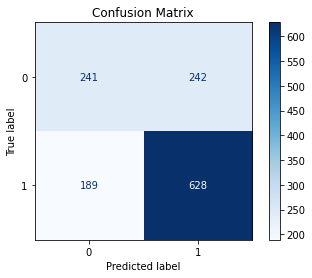

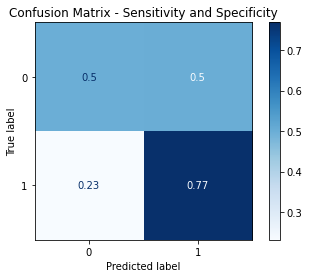

In [50]:
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test(clust_RP, Y_BC)
RP_est_lbl = MLPClassifier(hidden_layer_sizes=(10,5,5), solver='adam', activation='relu', learning_rate_init=0.01, max_iter=10000, random_state=18)
train_samp_RP_lbl, NN_train_score_RP_lbl, NN_fit_time_RP_lbl, NN_pred_time_RP_lbl, NN_cv_score_RP_lbl = evaluate_nn(RP_est_lbl, X_train_nn, y_train_nn,title="Neural Net Wine Quality: Randomize Projection")
classification_report(RP_est_lbl, X_train_nn, X_test_nn, y_train_nn, y_test_nn )

#### Random Forest Classifier

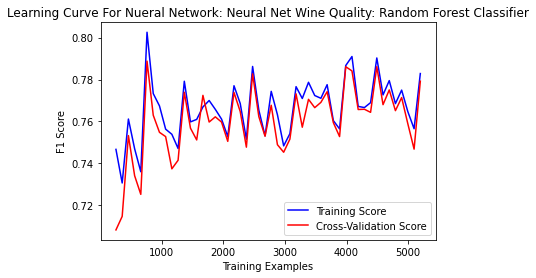

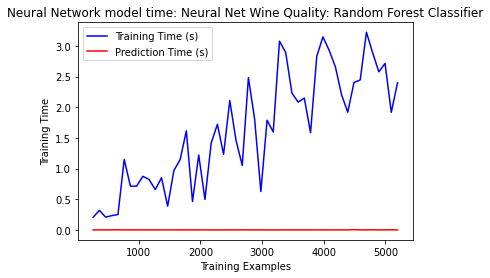

Classification Report
*****************************************************
Training Time:   2.29691
Prediction Time: 0.00053

F1 Score:  0.77
Accuracy:  0.69     AUC:       0.65
Precision: 0.72     Recall:    0.81
*****************************************************
              precision    recall  f1-score   support

           0       0.61      0.49      0.54       491
           1       0.72      0.81      0.77       809

    accuracy                           0.69      1300
   macro avg       0.67      0.65      0.66      1300
weighted avg       0.68      0.69      0.68      1300

*****************************************************


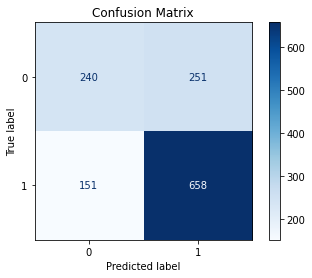

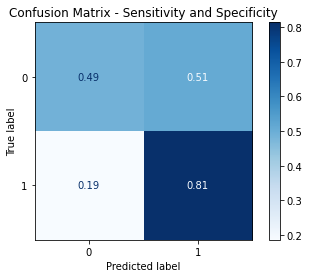

In [51]:
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test(clust_rfc, Y_BC)
rfc_est_lbl = MLPClassifier(hidden_layer_sizes=(10,5,5), solver='adam', activation='logistic', learning_rate_init=0.01, max_iter=10000,random_state=18)
train_samp_rfc_lbl, NN_train_score_rfc_lbl, NN_fit_time_rfc_lbl, NN_pred_time_rfc_lbl, NN_cv_score_rfc_lbl = evaluate_nn(rfc_est_lbl, X_train_nn, y_train_nn,title="Neural Net Wine Quality: Random Forest Classifier")
classification_report(rfc_est_lbl, X_train_nn, X_test_nn, y_train_nn, y_test_nn)

#### Comparision plots

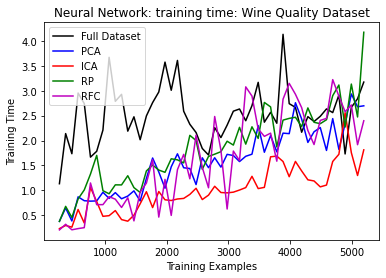

In [52]:
plot_fit_time(train_samp_full_lbl, NN_fit_time_full_lbl, NN_fit_time_pca_lbl, NN_fit_time_ica_lbl, NN_fit_time_RP_lbl, NN_fit_time_rfc_lbl, 'Wine Quality Dataset')       

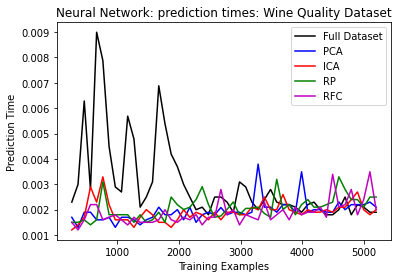

In [53]:
plot_pred_time(train_samp_full_lbl, NN_pred_time_full_lbl, NN_pred_time_pca_lbl, NN_pred_time_ica_lbl, NN_pred_time_RP_lbl, NN_pred_time_rfc_lbl, 'Wine Quality Dataset')   

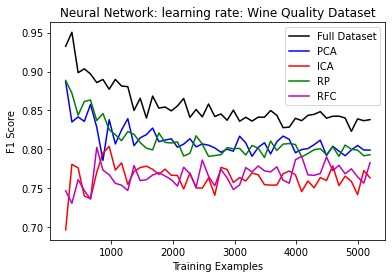

In [54]:
plot_learn_time(train_samp_full_lbl, NN_train_score_full_lbl, NN_train_score_pca_lbl, NN_train_score_ica_lbl, NN_train_score_RP_lbl, NN_train_score_rfc_lbl, 'Wine Quality Dataset')

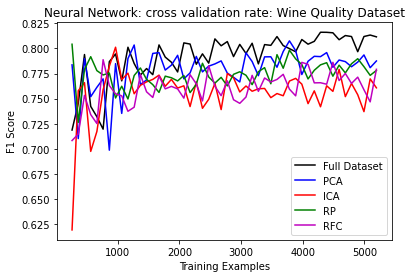

In [55]:
plot_cv_time(train_samp_full_lbl,NN_cv_score_full_lbl, NN_cv_score_pca_lbl, NN_cv_score_ica_lbl, NN_cv_score_RP_lbl, NN_cv_score_rfc_lbl, 'Wine Quality Dataset')